# Supervised Learning Methods for identifying Dolphin Attacks

## 1. Import Data

In [4]:
import os
import librosa
import librosa.display
import glob
import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
#Return audio Features from input file
def getAudioFeatures(file):
    sample, sr = librosa.load(file)
    mfcc = librosa.feature.mfcc(y=sample, sr=sr, n_mfcc=4)
    return mfcc
    

In [6]:
#Define paths
GOOGLE_ATTACKS = ['./samples/google_attacks/'+x for x in os.listdir('./samples/google_attacks/')]
GOOGLE_NORMAL = ['./samples/google_normal/'+x for x in os.listdir('./samples/google_normal/')]


#Return training/test samples 
def buildData(normal_path, attack_path, test_ratio=0.25):
    X = []
    y = []
    #Get index for attacks
    numAttacks = len(attack_path)
    attack_test_index = np.random.randint(0, numAttacks, int(test_ratio*numAttacks))
    attack_train_index = np.array([i for i in range(numAttacks) if i not in attack_test_index])
    #Get index for normal
    numNormal = len(normal_path)
    normal_test_index = np.random.randint(0, numNormal, int(test_ratio*numNormal))
    normal_train_index = np.array([i for i in range(numNormal) if i not in normal_test_index])

    #Start building data sets
    Xtrain, Xtest, Ytrain, Ytest = [], [], [], []
    for i in attack_train_index:
        '''TRAIN Attacks'''
        mfcc_attack = getAudioFeatures(GOOGLE_ATTACKS[i])
        Xtrain.append(mfcc_attack)
        Ytrain.append(np.ones(mfcc_attack.shape[1])) #attack=1
    for i in attack_test_index:
        '''TEST Attacks'''
        mfcc_attack = getAudioFeatures(GOOGLE_ATTACKS[i])
        Xtest.append(mfcc_attack)
        Ytest.append(np.ones(mfcc_attack.shape[1])) #attack=1   
    for i in normal_train_index:
        '''Train Normal'''
        mfcc_normal = getAudioFeatures(GOOGLE_NORMAL[i])
        Xtrain.append(mfcc_normal)
        Ytrain.append(np.zeros(mfcc_normal.shape[1])) #normal=0
    for i in normal_test_index:
        '''Test Normal'''
        mfcc_normal = getAudioFeatures(GOOGLE_NORMAL[i])
        Xtest.append(mfcc_normal)
        Ytest.append(np.zeros(mfcc_normal.shape[1])) #normal=0    
    Xtrain = np.hstack(Xtrain).T
    Ytrain = np.hstack(Ytrain)
    Xtest = np.hstack(Xtest).T
    Ytest = np.hstack(Ytest)
    return Xtrain, Ytrain, Xtest, Ytest, normal_test_index, attack_test_index

In [7]:
#Get dataset
Xtrain, Ytrain, Xtest, Ytest, normalTestIndex, attackTestIndex = buildData(GOOGLE_NORMAL, GOOGLE_ATTACKS)
print ('Training: ', Xtrain.shape, Ytrain.shape)
print ('Testing: ', Xtest.shape, Ytest.shape)

Training:  (9331, 4) (9331,)
Testing:  (3004, 4) (3004,)


## 2. Train Model [Logistic Regression]

In [8]:
#Build a model

from sklearn import linear_model

lr = linear_model.LogisticRegression(random_state=42)
print (lr.fit(Xtrain,Ytrain))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [9]:
#Test model all test data points..

Ypredict = lr.predict(Xtest)
corr = np.average(Ypredict==Ytest)
err = 1-corr
print (corr, err)

0.996671105193 0.00332889480692


## Let's test on individual audio samples

In [10]:
#Check attack samples
error = []
for a in attackTestIndex:
    mfcc = getAudioFeatures(GOOGLE_ATTACKS[a]).T
    ypred = lr.predict(mfcc)
    print (GOOGLE_ATTACKS[a], np.average(ypred))
    error.append(1-np.average(ypred))
    
#Check normal samples
for a in normalTestIndex:
    mfcc = getAudioFeatures(GOOGLE_NORMAL[a]).T
    ypred = lr.predict(mfcc)
    print (GOOGLE_NORMAL[a], np.average(ypred))
    error.append(np.average(ypred))
#error = np.absolute(error)    
print (error)
mse = np.mean(error) #For test samples ALL   
print ('MSE: ', mse)

./samples/google_attacks/SetAlarm11.wav 1.0
./samples/google_attacks/OpenCitibankApp.wav 1.0
./samples/google_attacks/HowManySuperBowlsPatroitsWin.wav 1.0
./samples/google_attacks/BookFlightVegas.wav 0.995433789954
./samples/google_attacks/TrophiesManchesterUnited.wav 0.97572815534
./samples/google_normal/google_normal_WhatsTheTemperatureNow.wav 0.0140186915888
./samples/google_normal/google_normal_EmailSadullah.wav 0.000969932104753
./samples/google_normal/google_normal_OpenBankOfAmericaApp.wav 0.0
./samples/google_normal/google_normal_PlayShakiraYoutube.wav 0.0
./samples/google_normal/google_normal_OpenCitibankApp.wav 0.0
[0.0, 0.0, 0.0, 0.0045662100456621557, 0.024271844660194164, 0.014018691588785047, 0.00096993210475266732, 0.0, 0.0, 0.0]
MSE:  0.00438266783994


In [11]:

#Looking for important features
print(lr.coef_)

[[ 0.03201323  0.10943394  0.19639205  0.10313681]]


In [12]:
print(np.std(Xtrain, 0)*lr.coef_)

[[ 4.73268695  6.63030996  9.0369556   2.6290749 ]]


In [13]:
print (getAudioFeatures(GOOGLE_NORMAL[0]))

[[-648.75156566 -647.01827456 -654.18567029 ..., -637.02252225
  -625.31125619 -652.34266086]
 [  98.45524884   99.62522044   93.68285271 ...,   79.63355356
    77.39552442   82.76359742]
 [  21.80004462   17.1020087    16.50995608 ...,   20.65546669
    17.22940471   17.44211898]
 [   6.31829334   -1.08931303   -1.94903106 ...,   -6.54193074
    -8.79254212   -5.07810797]]


In [14]:
# Check new google ones for NORMAL?
a1 = getAudioFeatures('./samples/location_normal.wav').T
ypred = lr.predict(a1)
print (np.average(ypred))

a1 = getAudioFeatures('./samples/statue_normal.wav').T
ypred = lr.predict(a1)
print (np.average(ypred))

0.194174757282
0.362637362637


Frequency vs. Time
./samples/google_attacks/TextSadullah.wav ./samples/google_normal/google_normal_TextSadullah.wav


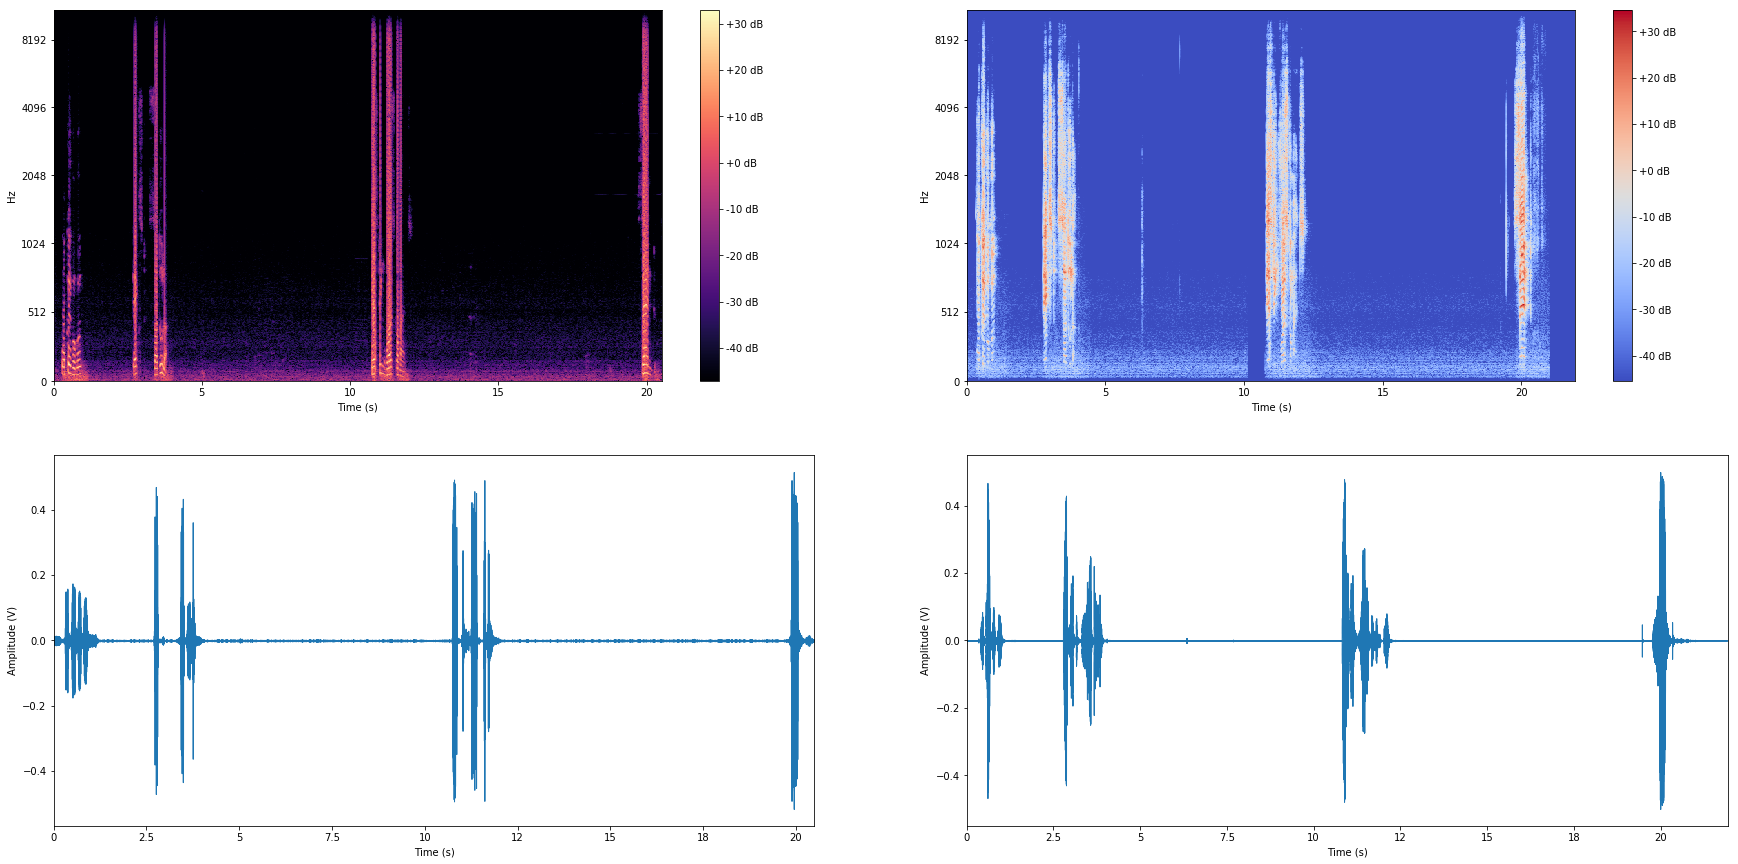

In [34]:

#NEW PLOT: TEXT SADULLAH
plt.figure(figsize=(30, 15))
print ('Frequency vs. Time')
for i in range(18,19):
    print (GOOGLE_ATTACKS[i], GOOGLE_NORMAL[i])
    #Load samples
    sa, attack_sr = librosa.load(GOOGLE_ATTACKS[i])
    attack_sample = librosa.amplitude_to_db(librosa.stft(sa))
    sn, normal_sr = librosa.load(GOOGLE_NORMAL[i])
    normal_sample = librosa.amplitude_to_db(librosa.stft(sn))
    #Display Attack
    plt.subplot(2, 2, 1)
    librosa.display.specshow(attack_sample, x_axis='time', y_axis='mel')
    plt.xlabel("Time (s)")
    plt.colorbar(format='%+2.0f dB')
    #Display Normal
    plt.subplot(2, 2, 2)
    librosa.display.specshow(normal_sample, x_axis='time', y_axis='mel')
    plt.xlabel("Time (s)")
    plt.colorbar(format='%+2.0f dB')
    #Waveform attack
    plt.subplot(2,2,3)
    plt.ylabel("Amplitude (V)")
    librosa.display.waveplot(sa,  x_axis='time')
    plt.xlabel("Time (s)")
    #Waveform attack
    plt.subplot(2,2,4)
    plt.ylabel("Amplitude (V)")
    librosa.display.waveplot(sn,  x_axis='time')
    plt.xlabel("Time (s)")


##  Number of MFCCs vs. Average loss

In [21]:
#Return audio Features from input file
def getAudioFeaturesN(file, n):
    sample, sr = librosa.load(file)
    mfcc = librosa.feature.mfcc(y=sample, sr=sr, n_mfcc=n)
    return mfcc

#Return random Training/Testing index 
def buildIndexN(normal_path, attack_path):
    print ('\tGetting index')
    #Get index for attacks
    numAttacks = len(attack_path)
    attack_test_index = np.random.randint(0, numAttacks, 10)
    attack_train_index = np.array([i for i in range(numAttacks) if i not in attack_test_index])
    #Get index for normal
    numNormal = len(normal_path)
    normal_test_index = np.random.randint(0, numNormal, 10)
    normal_train_index = np.array([i for i in range(numNormal) if i not in normal_test_index])
    return attack_train_index, attack_test_index, normal_train_index, normal_test_index

#Return training/test samples 
def buildDataN(attack_train_index, attack_test_index, normal_train_index, normal_test_index, n):  
    print ('\tBuilding DataSet, n=', n)
    #Start building data sets
    Xtrain, Xtest, Ytrain, Ytest = [], [], [], []
    for i in attack_train_index:
        '''TRAIN Attacks'''
        mfcc_attack = getAudioFeaturesN(GOOGLE_ATTACKS[i], n)
        Xtrain.append(mfcc_attack)
        Ytrain.append(np.ones(mfcc_attack.shape[1])) #attack=1
    for i in attack_test_index:
        '''TEST Attacks'''
        mfcc_attack = getAudioFeaturesN(GOOGLE_ATTACKS[i], n)
        Xtest.append(mfcc_attack)
        Ytest.append(np.ones(mfcc_attack.shape[1])) #attack=1   
    for i in normal_train_index:
        '''Train Normal'''
        mfcc_normal = getAudioFeaturesN(GOOGLE_NORMAL[i], n)
        Xtrain.append(mfcc_normal)
        Ytrain.append(np.zeros(mfcc_normal.shape[1])) #normal=0
    for i in normal_test_index:
        '''Test Normal'''
        mfcc_normal = getAudioFeaturesN(GOOGLE_NORMAL[i], n)
        Xtest.append(mfcc_normal)
        Ytest.append(np.zeros(mfcc_normal.shape[1])) #normal=0    
    Xtrain = np.hstack(Xtrain).T
    Ytrain = np.hstack(Ytrain)
    Xtest = np.hstack(Xtest).T
    Ytest = np.hstack(Ytest)
    return Xtrain, Ytrain, Xtest, Ytest

#Run one simulation step for n:1-10
def runSim():
    #Get random index
    attack_train_index, attack_test_index, normal_train_index, normal_test_index = buildIndexN(GOOGLE_NORMAL, GOOGLE_ATTACKS)
    loss = np.zeros(10)
    for i in range(10):
        #Get dataSet
        Xtrain, Ytrain, Xtest, Ytest = buildDataN(attack_train_index, attack_test_index, normal_train_index, normal_test_index, i+1)
        #Build Model
        print ('\tBuilding Model')
        lr = linear_model.LogisticRegression()
        lr.fit(Xtrain,Ytrain)
        #Test Model
        print ('\tPredicting Model')
        Ypredict = lr.predict(Xtest)
        corr = np.average(Ypredict==Ytest)
        err = 1-corr
        loss[i] = err
    return loss            

In [22]:
#Get avg loss for 50 runs
import time

numSim = 50
losses = np.zeros(10)
for i in range(numSim):
    print ('Run Started: ', i)
    start = time.time()
    losses += runSim()
    print ('Run Finished in ', time.time()-start)
losses /= numSim
print (losses)

Run Started:  0
	Getting index
	Building DataSet, n= 1
	Building Model
	Predicting Model
	Building DataSet, n= 2
	Building Model
	Predicting Model
	Building DataSet, n= 3
	Building Model
	Predicting Model
	Building DataSet, n= 4
	Building Model
	Predicting Model
	Building DataSet, n= 5
	Building Model
	Predicting Model
	Building DataSet, n= 6
	Building Model
	Predicting Model
	Building DataSet, n= 7
	Building Model
	Predicting Model
	Building DataSet, n= 8
	Building Model
	Predicting Model
	Building DataSet, n= 9
	Building Model
	Predicting Model
	Building DataSet, n= 10
	Building Model
	Predicting Model
Run Finished in  185.76019072532654
Run Started:  1
	Getting index
	Building DataSet, n= 1
	Building Model
	Predicting Model
	Building DataSet, n= 2
	Building Model
	Predicting Model
	Building DataSet, n= 3
	Building Model
	Predicting Model
	Building DataSet, n= 4
	Building Model
	Predicting Model
	Building DataSet, n= 5
	Building Model
	Predicting Model
	Building DataSet, n= 6
	Buildi

	Building Model
	Predicting Model
	Building DataSet, n= 9
	Building Model
	Predicting Model
	Building DataSet, n= 10
	Building Model
	Predicting Model
Run Finished in  147.9077091217041
Run Started:  13
	Getting index
	Building DataSet, n= 1
	Building Model
	Predicting Model
	Building DataSet, n= 2
	Building Model
	Predicting Model
	Building DataSet, n= 3
	Building Model
	Predicting Model
	Building DataSet, n= 4
	Building Model
	Predicting Model
	Building DataSet, n= 5
	Building Model
	Predicting Model
	Building DataSet, n= 6
	Building Model
	Predicting Model
	Building DataSet, n= 7
	Building Model
	Predicting Model
	Building DataSet, n= 8
	Building Model
	Predicting Model
	Building DataSet, n= 9
	Building Model
	Predicting Model
	Building DataSet, n= 10
	Building Model
	Predicting Model
Run Finished in  136.8128318786621
Run Started:  14
	Getting index
	Building DataSet, n= 1
	Building Model
	Predicting Model
	Building DataSet, n= 2
	Building Model
	Predicting Model
	Building DataSet,

	Building Model
	Predicting Model
	Building DataSet, n= 5
	Building Model
	Predicting Model
	Building DataSet, n= 6
	Building Model
	Predicting Model
	Building DataSet, n= 7
	Building Model
	Predicting Model
	Building DataSet, n= 8
	Building Model
	Predicting Model
	Building DataSet, n= 9
	Building Model
	Predicting Model
	Building DataSet, n= 10
	Building Model
	Predicting Model
Run Finished in  125.60828948020935
Run Started:  26
	Getting index
	Building DataSet, n= 1
	Building Model
	Predicting Model
	Building DataSet, n= 2
	Building Model
	Predicting Model
	Building DataSet, n= 3
	Building Model
	Predicting Model
	Building DataSet, n= 4
	Building Model
	Predicting Model
	Building DataSet, n= 5
	Building Model
	Predicting Model
	Building DataSet, n= 6
	Building Model
	Predicting Model
	Building DataSet, n= 7
	Building Model
	Predicting Model
	Building DataSet, n= 8
	Building Model
	Predicting Model
	Building DataSet, n= 9
	Building Model
	Predicting Model
	Building DataSet, n= 10
	B

	Building Model
	Predicting Model
	Building DataSet, n= 2
	Building Model
	Predicting Model
	Building DataSet, n= 3
	Building Model
	Predicting Model
	Building DataSet, n= 4
	Building Model
	Predicting Model
	Building DataSet, n= 5
	Building Model
	Predicting Model
	Building DataSet, n= 6
	Building Model
	Predicting Model
	Building DataSet, n= 7
	Building Model
	Predicting Model
	Building DataSet, n= 8
	Building Model
	Predicting Model
	Building DataSet, n= 9
	Building Model
	Predicting Model
	Building DataSet, n= 10
	Building Model
	Predicting Model
Run Finished in  133.92513942718506
Run Started:  39
	Getting index
	Building DataSet, n= 1
	Building Model
	Predicting Model
	Building DataSet, n= 2
	Building Model
	Predicting Model
	Building DataSet, n= 3
	Building Model
	Predicting Model
	Building DataSet, n= 4
	Building Model
	Predicting Model
	Building DataSet, n= 5
	Building Model
	Predicting Model
	Building DataSet, n= 6
	Building Model
	Predicting Model
	Building DataSet, n= 7
	Bu

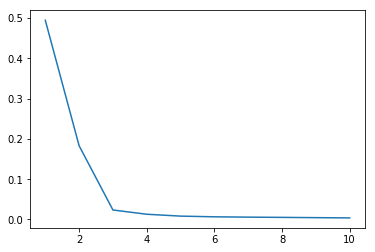

In [24]:
plt.plot(range(1,11), losses)

In [31]:
losses*100

array([ 49.41778183,  18.28713177,   2.35227975,   1.29745634,
         0.83274307,   0.66078958,   0.57994239,   0.5193662 ,
         0.45348465,   0.38690062])